In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd

C:\Users\Bill\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Bill\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
aggro = pd.read_csv("aggressive.csv")
defen = pd.read_csv("defensive.csv")

In [3]:
print(len(aggro))
print(len(defen))

11118
11573


In [4]:
print(aggro.head())

        Event Site        Date Round                White  \
0  Earl tourn    ?  1906.??.??     ?               Savrov   
1  Earl tourn    ?  1906.??.??     ?                Giese   
2  Earl tourn    ?  1906.??.??     ?  Alekhine, Alexander   
3  Earl tourn    ?  1906.??.??     ?  Alekhine, Alexander   
4  Earl tourn    ?  1906.??.??     ?            Manko, V.   

                 Black  Result  BlackElo  WhiteElo  ECO  Move Count  \
0  Alekhine, Alexander     0-1       NaN       NaN  C30          44   
1  Alekhine, Alexander     0-1       NaN       NaN  C47          17   
2         Ljubimov, T.  Jan-00       NaN       NaN  C58          38   
3           Romaskevic  Jan-00       NaN       NaN  C20          18   
4  Alekhine, Alexander  Jan-00       NaN       NaN  C52          35   

   Average Material Threatened  Gambit Count  Check Count  \
0                     1.840909             0            8   
1                     1.235294             0            1   
2                     1

In [5]:
print(defen.head())

   Average Board Evaluation  Average Material Threatened               Black  \
0                  4.551111                     1.888889  Anand, Viswanathan   
1                  4.768966                     2.362069  Anand, Viswanathan   
2                  9.956000                     2.880000  Anand, Viswanathan   
3                  5.188000                     1.320000       Siddiqui, MA.   
4                  6.069565                     3.217391           Shah, SP.   

   BlackElo BlackTeam BlackTeamCountry  Check Count        Date  ECO  \
0       NaN       NaN              NaN           11  1981/12/??  C42   
1       NaN       NaN              NaN            0  1982/??/??  B43   
2       NaN       NaN              NaN            1  1982/??/??  E87   
3       NaN       NaN              NaN            8  1982/01/??  B06   
4       NaN       NaN              NaN            1  1983/10/??  B98   

                             Event    ...      Round SetUp        Site  \
0           

In [6]:
total = pd.concat([aggro, defen])
drops = ["Black", "BlackElo", "BlackTeam", "BlackTeamCountry", "Date", "Event", 
         "EventCategory", "EventCountry", "EventDate", "EventRounds", "EventType", "FEN", "PlyCount", "Result",
        "Round", "SetUp", "Site", "Source", "SourceDate", "White", "WhiteElo", "WhiteTeam", "WhiteTeamCountry"]
total = total.drop(drops, axis=1)

number = LabelEncoder()
total["ECO"] = number.fit_transform(total["ECO"].astype('str'))
print(total.columns)

Index(['Aggressive', 'Average Board Evaluation', 'Average Material Threatened',
       'Check Count', 'ECO', 'Gambit Count', 'Move Count'],
      dtype='object')


In [7]:
X = total.drop(["Aggressive"], axis=1)
y = total["Aggressive"]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
scores = []
classifiers = []
nmin = 1
nmax = 200
for n in range(nmin, nmax):
    forest = RandomForestClassifier(n_estimators = n)
    forest.fit(X_train, y_train)
    classifiers.append(forest)
    scores.append(forest.score(X_test, y_test))

In [10]:
amax = np.argmax(scores)
print(scores[amax])

0.6812658565896649


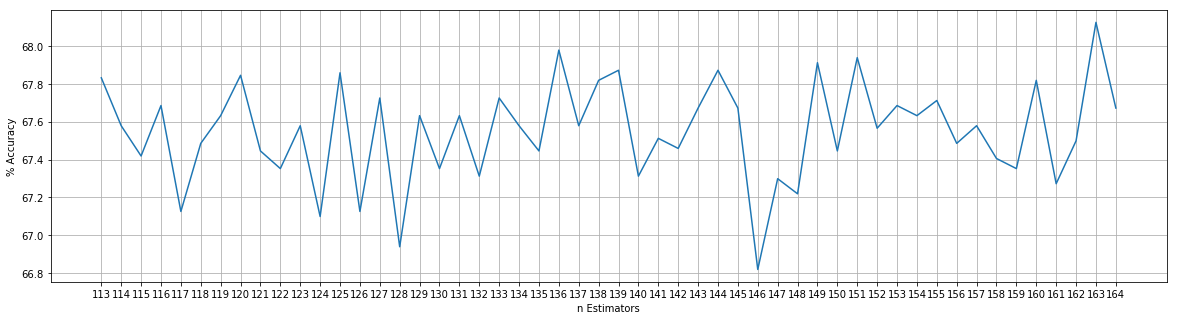

In [12]:
x = np.array([i for i in range(amax - 50, amax + 2)])
scores = np.array(scores)

plt.figure(figsize=(20,5));
plt.plot(x, [r * 100 for r in [scores[i] for i in x]]);
plt.xticks(x, [str(i) for i in x])
plt.grid(True)
plt.ylabel("% Accuracy")
plt.xlabel("n Estimators")
plt.show();

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
print(amax)
print(scores[amax])

f = classifiers[amax]
y_pred = f.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

163
0.6812658565896649


Confusion matrix, without normalization
[[2691 1121]
 [1266 2411]]
Normalized confusion matrix
[[0.71 0.29]
 [0.34 0.66]]


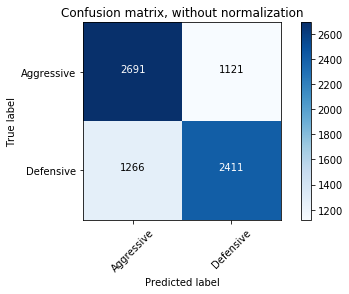

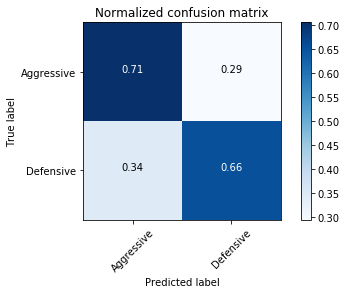

In [15]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Aggressive", "Defensive"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Aggressive", "Defensive"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
cvscore = cross_val_score(f, X_train, y_train, cv=10)
print(np.mean(cvscore))

0.671622345943703


In [ ]:
clf = RandomForestClassifier(n_jobs=-1)
arr = [i*5 for i in range(1, 20)]
param_grid = {
    'n_estimators': arr, # up to 100 trees
    'max_depth': arr,
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_params_)
print(grid_clf.grid_scores_)

In [ ]:
sqrtf = RandomForestClassifier(n_estimators=50, max_depth=20, max_features='sqrt')
sqrtf.fit(X_train, y_train)
print(np.mean(cross_val_score(sqrtf, X_train, y_train, cv=10)))

In [ ]:
print(grid_clf.best_params_)
print(grid_clf.grid_scores_)

In [ ]:
f = grid_clf.best_estimator_
print(f.score(X_test, y_test))